# Made by Bohdan Bilokon, FB-11mp

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 1. Sequence generation
### seq2seq + ReacherForsing

dataset: [Ukrainian - English](https://www.manythings.org/anki/ukr-eng.zip)

#### Configuration

In [2]:
batch_size = 64
epochs = 50
latent_dim = 128
num_samples = 10000
data_path = "ukr-eng/ukr.txt"

#### Prepare the data

In [3]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

In [4]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [5]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [6]:
print("Number of samples:", len(input_texts))
print("Number of unique input words:", num_encoder_tokens)
print("Number of unique output words:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input words: 72
Number of unique output words: 95
Max sequence length for inputs: 15
Max sequence length for outputs: 54


In [7]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [8]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [9]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

#### Build the model

In [10]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [11]:
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [12]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

#### Train the model

In [13]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [14]:
model.fit([encoder_input_data, decoder_input_data],
          decoder_target_data,
          batch_size = batch_size,
          epochs = epochs,
          validation_split = 0.2,
)

Epoch 1/50
125/125 [==============================] - 16s 103ms/step - loss: 1.1617 - accuracy: 0.7443 - val_loss: 1.0467 - val_accuracy: 0.7290
Epoch 2/50
125/125 [==============================] - 13s 108ms/step - loss: 0.8529 - accuracy: 0.7755 - val_loss: 0.8758 - val_accuracy: 0.7688
Epoch 3/50
125/125 [==============================] - 12s 97ms/step - loss: 0.7319 - accuracy: 0.8037 - val_loss: 0.7565 - val_accuracy: 0.7936
Epoch 4/50
125/125 [==============================] - 12s 99ms/step - loss: 0.6420 - accuracy: 0.8203 - val_loss: 0.6764 - val_accuracy: 0.8091
Epoch 5/50
125/125 [==============================] - 15s 119ms/step - loss: 0.5903 - accuracy: 0.8319 - val_loss: 0.6373 - val_accuracy: 0.8170
Epoch 6/50
125/125 [==============================] - 12s 99ms/step - loss: 0.5572 - accuracy: 0.8391 - val_loss: 0.6152 - val_accuracy: 0.8225
Epoch 7/50
125/125 [==============================] - 13s 104ms/step - loss: 0.5339 - accuracy: 0.8447 - val_loss: 0.5910 - val_accur

#### Dictionary with words

In [15]:
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [16]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)

In [17]:
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

#### Reverse

In [18]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

#### Translate func

In [19]:
def translate_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0
    stop_condition = False
    translated_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        translated_sentence += sampled_char
        if sampled_char == "\n" or len(translated_sentence) > max_decoder_seq_length:
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return translated_sentence

#### Generate examples

In [20]:
for seq_index in range(0, 1000, 20):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    translated_sequence = translate_sequence(input_seq)
    print("============================================================")
    print("Original sentence:", input_texts[seq_index])
    print("Translated sentence:", translated_sequence)

Original sentence: Go.
Translated sentence: Зрозлив.

Original sentence: Begin.
Translated sentence: Принеси його.

Original sentence: I won.
Translated sentence: Я почер.

Original sentence: Got it?
Translated sentence: Зрозуміла?

Original sentence: I swim.
Translated sentence: Я повинна.

Original sentence: Thanks!
Translated sentence: Дякую!

Original sentence: Awesome!
Translated sentence: Почев!

Original sentence: Come on!
Translated sentence: Заходь!

Original sentence: Goodbye!
Translated sentence: Побачише!

Original sentence: Help us.
Translated sentence: Допоможи нам.

Original sentence: I dozed.
Translated sentence: Я піднявся.

Original sentence: I'm fat.
Translated sentence: Я застрятей.

Original sentence: Join us.
Translated sentence: Приподіться на мене.

Original sentence: Shut up!
Translated sentence: Спробуйте за мене!

Original sentence: We lost.
Translated sentence: Ми подемоглися.

Original sentence: You won.
Translated sentence: Ти в порядку.

Original sentence

## 2. Image generation

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape

from tensorflow.keras.datasets import cifar100

np.random.seed(1000)

In [22]:
num_classes = 100
(x_train, _), (_, _) = cifar100.load_data()
x_train = x_train[:10000,]
print(x_train.shape)

(10000, 32, 32, 3)


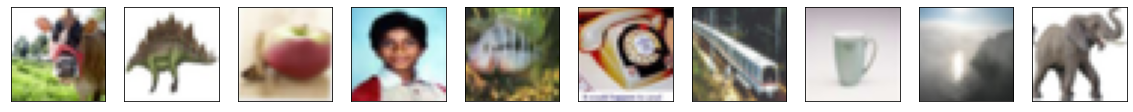

In [23]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [24]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalization [-1, 1]
x_train = np.clip(x_train, -1, 1)

In [25]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [26]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(64, (3,3), padding='same', input_shape=(32,32,3)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    return model

In [27]:
latent_dim = 100

def build_generator():
    model = Sequential()

    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [28]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [29]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0
    
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [30]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            generated_images = generator.predict(noise)
            
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 5 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0


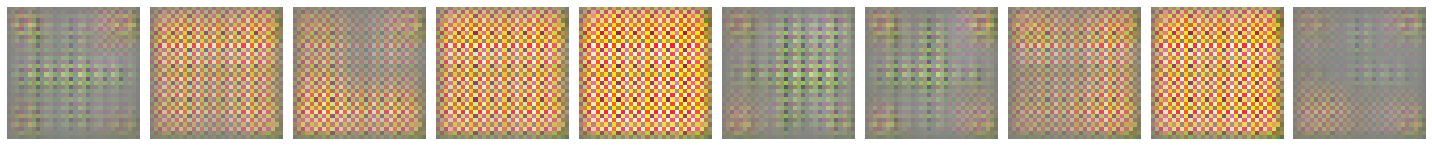

epoch:  5


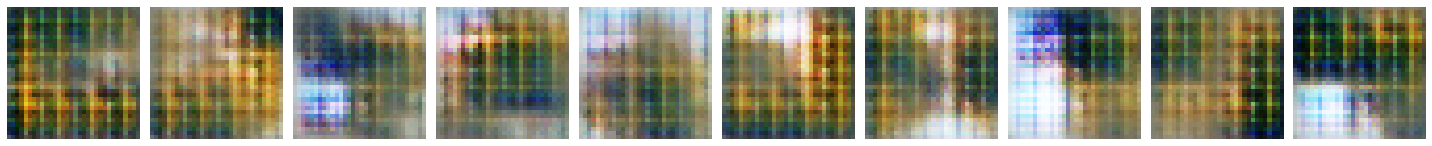

epoch:  10


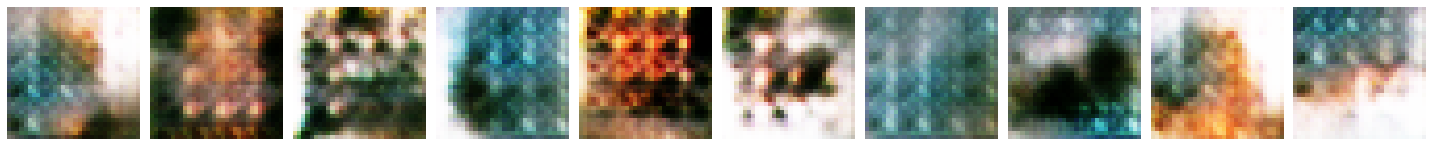

epoch:  15


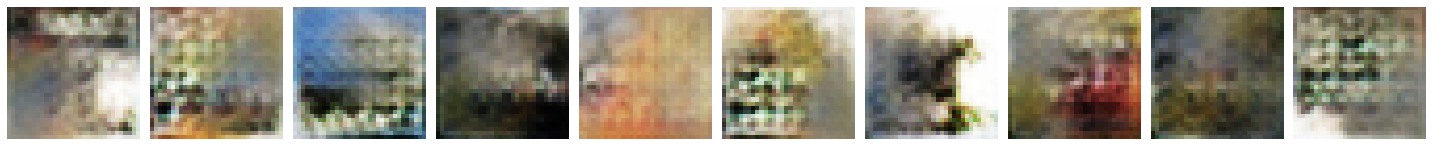

epoch:  20


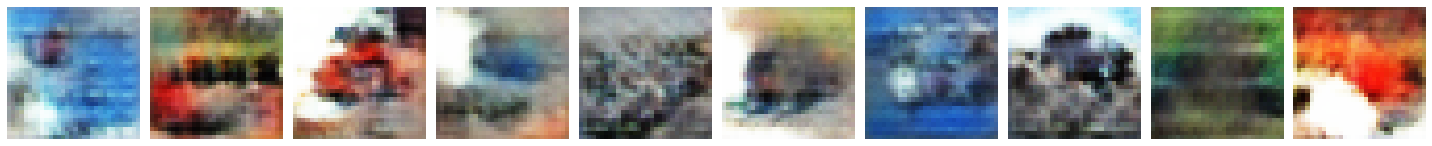

epoch:  25


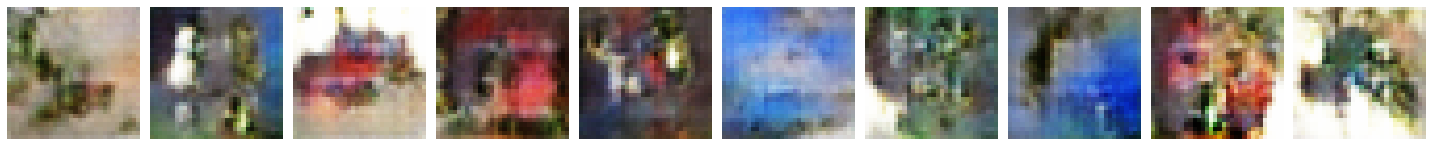

epoch:  30


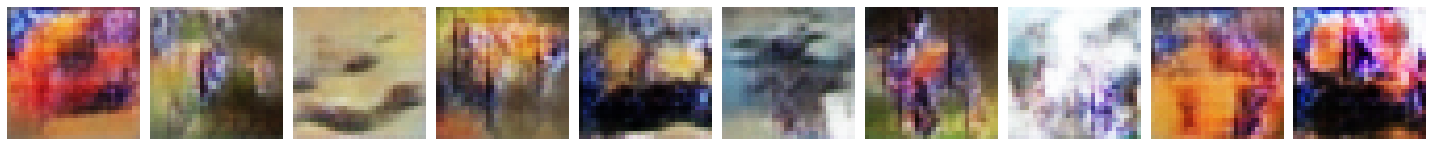

epoch:  35


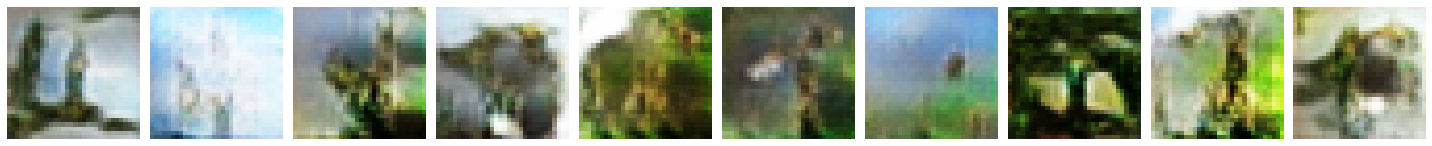

epoch:  40


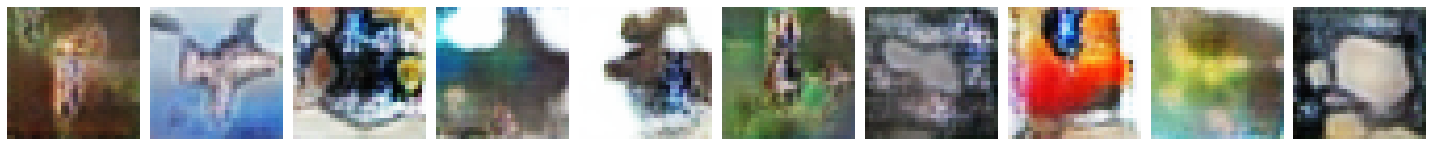

In [31]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)


epochs = 40
batch_size = 64
train_model(epochs, batch_size)

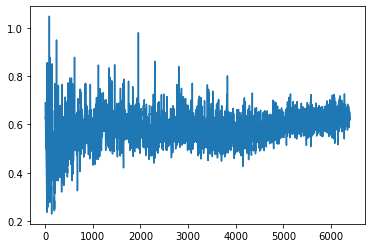

In [32]:
plt.plot(discrim_losses)